In [0]:
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
#                                   remove=['headers'],
                                 )
test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

In [0]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import text
import re

def no_num_tokenizer(document):
    words = [word for word in re.split('[^a-zA-Z]+', document) if len(word)>2]
    words = [word for word in words if word not in stop_words]
    return words

def feature_extraction(X_train,X_test):
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train)
    X_test_tfidf = tfidf_transformer.transform(X_test)
    print("Shape of X_train_tfidf: ",X_train_tfidf.shape)
    print("Shape of X_test_tfidf: ",X_test_tfidf.shape)
    return X_train_tfidf,X_test_tfidf

def create_binary(train_dataset,test_dataset):
    y_train =train_dataset.target.copy()
    y_train[y_train<=3] = 1
    y_train[y_train>3] = 0

    y_test =test_dataset.target.copy()
    y_test[y_test<=3] = 1
    y_test[y_test>3] = 0
    return y_train,y_test

stop_words = text.ENGLISH_STOP_WORDS
count_vect = CountVectorizer(stop_words=None, tokenizer=no_num_tokenizer, min_df=3)

In [0]:
X_train_counts = count_vect.fit_transform(train.data)
X_test_counts = count_vect.transform(test.data)
y_train,y_test = create_binary(train,test)
#print('Shape of Gnd Truth, Training:', y_train.shape)
#print('Shape of Gnd Truth, Test:', y_test.shape)

#print("Shape of X_train_counts: ",X_train_counts.shape)
#print("Shape of X_test_counts: ",X_test_counts.shape)
    
X_train_tfidf,X_test_tfidf = feature_extraction(X_train_counts,X_test_counts)

Shape of X_train_tfidf:  (4732, 16432)
Shape of X_test_tfidf:  (3150, 16432)


In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
from time import time

#km = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=30,
#                verbose=False, random_state=0)
km = KMeans(n_clusters=2, max_iter=1000, n_init=30,
                verbose=False, random_state=0)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_train_tfidf)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=2, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=False)
done in 230.373s


In [0]:
from sklearn import metrics
labels = y_train
contingency_matrix = metrics.cluster.contingency_matrix(y_train, km.labels_)

In [0]:
print(contingency_matrix)

[[1045 1344]
 [   2 2341]]


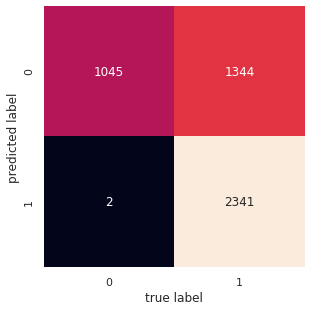

In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6.4,4.8]
import seaborn as sns; sns.set()  

mat = contingency_matrix
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels='01',
            yticklabels='01')
#NOT SURE IF THE AXIS' ARE CORRECT
plt.xlabel('true label')
plt.ylabel('predicted label');

In [0]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Adjusted Mutual Info Score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

Homogeneity: 0.258
Completeness: 0.339
V-measure: 0.293
Adjusted Rand-Index: 0.186
Adjusted Mutual Info Score: 0.293


In [0]:
#SVD and NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
#model = NMF(n_components=1000, random_state=0)
#W_train = model.fit_transform(X_train_tfidf)
#W_test = model.transform(X_test_tfidf)
SVD = TruncatedSVD(1000, random_state =0)
X_svd_train = SVD.fit_transform(X_train_tfidf)
X_svd_test = SVD.transform(X_test_tfidf)

Text(0.5, 0, 'r')

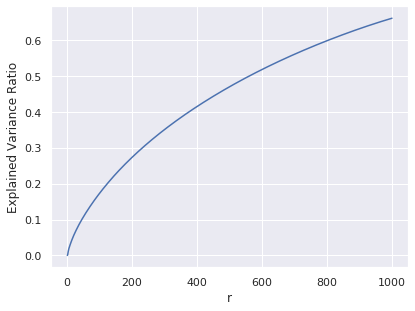

In [0]:
r = np.linspace(1,1000,1000)
SVD_variance = np.zeros(1000)
for i in range(1000):
  SVD_variance[i] = np.sum(SVD.explained_variance_ratio_[:i])
plt.plot(r,SVD_variance)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('r')

In [0]:
r = [1, 2, 3, 5, 10, 20, 50, 100, 300]
homogeneity_scores = np.zeros((len(r),2))
completeness_scores = np.zeros((len(r),2))
v_measure_scores = np.zeros((len(r),2))
adjusted_rand_scores = np.zeros((len(r),2))
adjusted_mutual_info_scores = np.zeros((len(r),2))

#Testing SVD parameters
for i in range(len(r)):
  current_r = r[i]
  km = KMeans(n_clusters=2, max_iter=1000, n_init=30, verbose=False, random_state=0)
  km.fit(X_svd_train[range(X_svd_train.shape[0]),:current_r])
  homogeneity_scores[i,0] = metrics.homogeneity_score(labels, km.labels_)
  completeness_scores[i,0] = metrics.completeness_score(labels, km.labels_)
  v_measure_scores[i,0] = metrics.v_measure_score(labels, km.labels_)
  adjusted_rand_scores[i,0] = metrics.adjusted_rand_score(labels, km.labels_)
  adjusted_mutual_info_scores[i,0] = metrics.adjusted_mutual_info_score(labels, km.labels_)

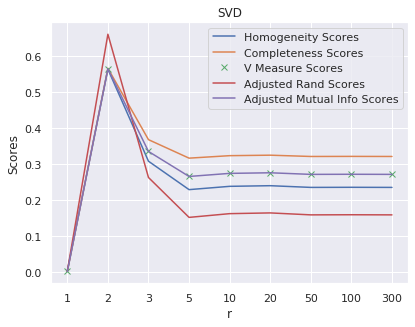

In [0]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(homogeneity_scores[:,0],label='Homogeneity Scores')
ax.plot(completeness_scores[:,0],label='Completeness Scores')
ax.plot(v_measure_scores[:,0],'x',label='V Measure Scores')
ax.plot(adjusted_rand_scores[:,0],label='Adjusted Rand Scores')
ax.plot(adjusted_mutual_info_scores[:,0],label='Adjusted Mutual Info Scores')
plt.xticks(np.arange(len(r)),('1', '2', '3', '5', '10', '20', '50', '100', '300'))
plt.xlabel('r')
plt.ylabel('Scores')
plt.title('SVD')
ax.legend()
plt.show()

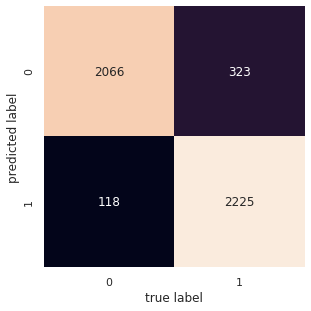

In [0]:
km = KMeans(n_clusters=2, max_iter=1000, n_init=30, verbose=False, random_state=0)
km.fit(X_svd_train[range(X_svd_train.shape[0]),:2])

plot_contingency_matrix(km,y_train)

In [0]:
#Testing NMF parameters
for i in range(len(r)):
  current_r = r[i]
  model = NMF(n_components=current_r, random_state=0)
  W_train = model.fit_transform(X_train_tfidf)
  km = KMeans(n_clusters=2, max_iter=1000, n_init=30, verbose=False, random_state=0)
  km.fit(W_train)
  homogeneity_scores[i,1] = metrics.homogeneity_score(labels, km.labels_)
  completeness_scores[i,1] = metrics.completeness_score(labels, km.labels_)
  v_measure_scores[i,1] = metrics.v_measure_score(labels, km.labels_)
  adjusted_rand_scores[i,1] = metrics.adjusted_rand_score(labels, km.labels_)
  adjusted_mutual_info_scores[i,1] = metrics.adjusted_mutual_info_score(labels, km.labels_)


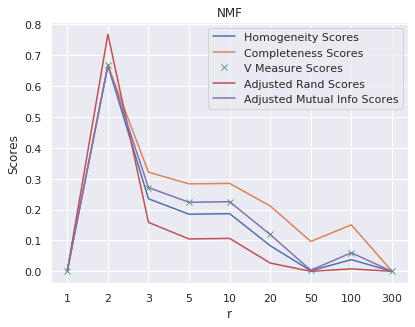

In [0]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(homogeneity_scores[:,1],label='Homogeneity Scores')
ax.plot(completeness_scores[:,1],label='Completeness Scores')
ax.plot(v_measure_scores[:,1],'x',label='V Measure Scores')
ax.plot(adjusted_rand_scores[:,1],label='Adjusted Rand Scores')
ax.plot(adjusted_mutual_info_scores[:,1],label='Adjusted Mutual Info Scores')
plt.xticks(np.arange(len(r)),('1', '2', '3', '5', '10', '20', '50', '100', '300'))
plt.xlabel('r')
plt.ylabel('Scores')
plt.title('NMF')
ax.legend()
plt.show()

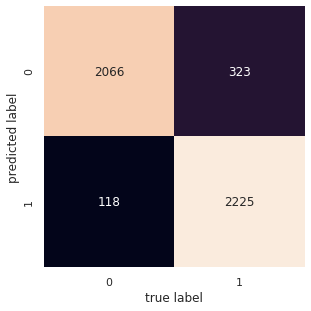

In [0]:
km = KMeans(n_clusters=2, max_iter=1000, n_init=30, verbose=False, random_state=0)
km.fit(X_svd_train[range(W_train.shape[0]),:2])

plot_contingency_matrix(km,y_train)


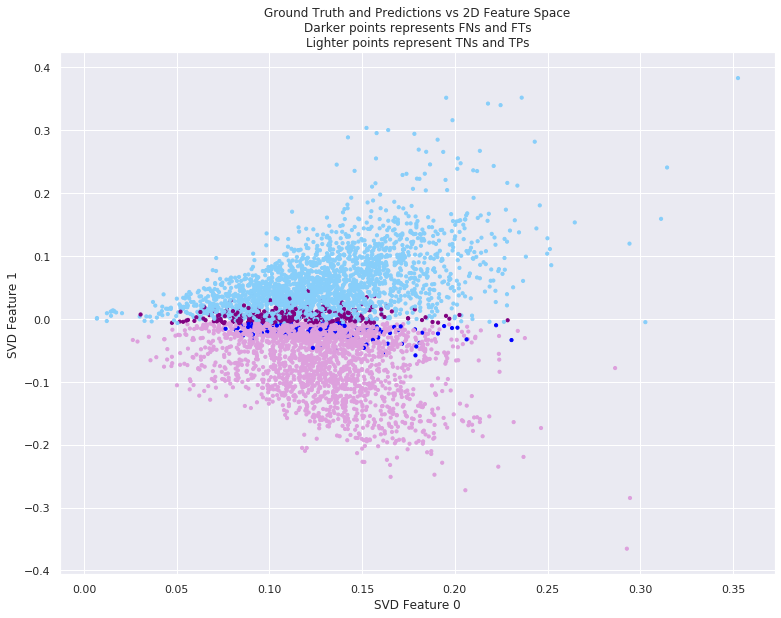

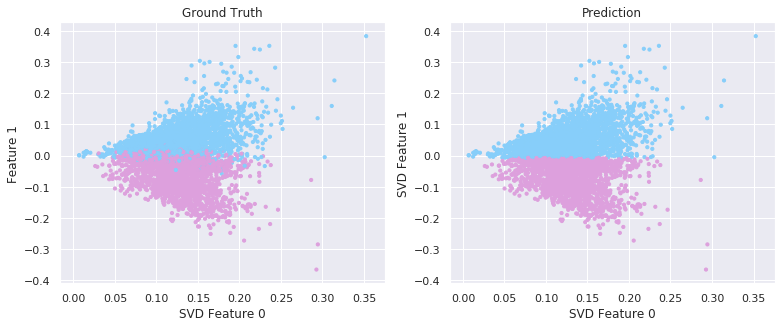

In [0]:
km = KMeans(n_clusters=2, max_iter=1000, n_init=30, verbose=False, random_state=0)
km.fit(X_svd_train[range(X_svd_train.shape[0]),:2])
fig = plt.figure(figsize=(2*6.4, 2*4.8))
ax = fig.add_subplot(111)
colors = []
for i in range(y_train.shape[0]):
  if y_train[i] == 1 and km.labels_[i]==1:
    colors.append('lightskyblue')
  elif y_train[i] == 0 and km.labels_[i]==0:
    colors.append('plum')
  elif y_train[i] == 1 and km.labels_[i]==0:
    colors.append('blue')
  else:
    colors.append('purple')

scatter = ax.scatter(X_svd_train[range(X_svd_train.shape[0]),0],X_svd_train[range(X_svd_train.shape[0]),1],c=colors,s=10)

ax.set_xlabel('SVD Feature 0')
ax.set_ylabel('SVD Feature 1')
plt.title('Ground Truth and Predictions vs 2D Feature Space\nDarker points represents FNs and FTs\nLighter points represent TNs and TPs')
fig.show()

scatter_gnd_truth(km,X_svd_train,y_train,'SVD Feature 0','Feature 1','Ground Truth')
scatter_predict(km,X_svd_train,y_train,'SVD Feature 0','SVD Feature 1','Prediction')

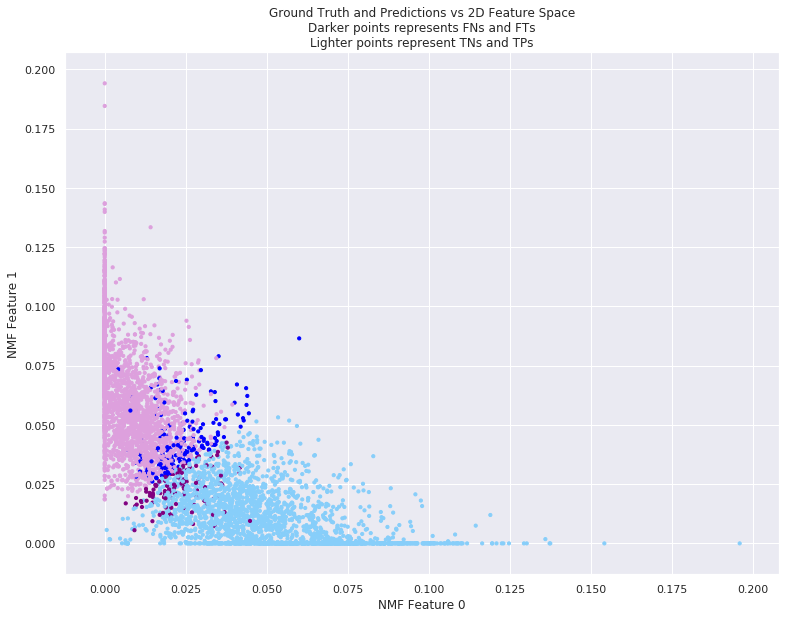

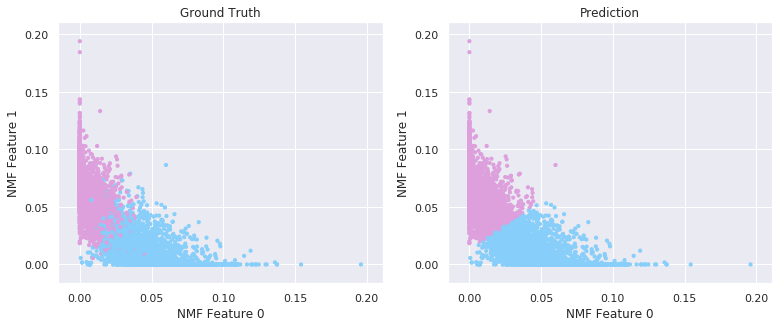

In [0]:
#best r is 2
model = NMF(n_components=2, random_state=0)
W_train = model.fit_transform(X_train_tfidf)
km = KMeans(n_clusters=2, max_iter=1000, n_init=30, verbose=False, random_state=0)
km.fit(W_train)
fig = plt.figure(figsize=(2*6.4, 2*4.8))
ax = fig.add_subplot(111)
colors = []
for i in range(y_train.shape[0]):
  if y_train[i] == 1 and km.labels_[i]==1:
    colors.append('lightskyblue')
  elif y_train[i] == 0 and km.labels_[i]==0:
    colors.append('plum')
  elif y_train[i] == 1 and km.labels_[i]==0:
    colors.append('blue')
  else:
    colors.append('purple')
scatter = ax.scatter(W_train[range(X_svd_train.shape[0]),0],W_train[range(X_svd_train.shape[0]),1],c=colors,s=10)
ax.set_xlabel('NMF Feature 0')
ax.set_ylabel('NMF Feature 1')
plt.title('Ground Truth and Predictions vs 2D Feature Space\nDarker points represents FNs and FTs\nLighter points represent TNs and TPs')
fig.show()

scatter_gnd_truth(km,W_train,y_train,'NMF Feature 0','NMF Feature 1','Ground Truth')
scatter_predict(km,W_train,y_train,'NMF Feature 0','NMF Feature 1','Prediction')

In [0]:
import sys 
def plot_contingency_matrix(model,y):
  fig = plt.figure()
  contingency_matrix = metrics.cluster.contingency_matrix(y, model.labels_)

  mat = contingency_matrix
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
              xticklabels='01',
              yticklabels='01')
  #NOT SURE IF THE AXIS' ARE CORRECT
  plt.xlabel('true label')
  plt.ylabel('predicted label');

def unit_variance_transformer(train,test):
  train_unit_variance = np.zeros(train.shape)
  test_unit_variance = np.zeros(test.shape)
  for i in range(train.shape[1]):
    train_unit_variance[:,i] = train[:,i]/train[:,i].std()
    test_unit_variance[:,i] = test[:,i]/test[:,i].std()
  return train_unit_variance, test_unit_variance

def log_nl_transformer(train,test):
  train_log_nl = np.zeros(train.shape)
  test_log_nl = np.zeros(test.shape)
  for i in range(train.shape[1]):
    train_log_nl[:,i] = np.log(train[:,i]+0.001)
    test_log_nl[:,i] = np.log(test[:,i]+0.001)
  return train_log_nl, test_log_nl


def scores(model, labels):
  scores = []
  scores.append(metrics.homogeneity_score(labels, model.labels_))
  scores.append(metrics.completeness_score(labels, model.labels_))
  scores.append(metrics.v_measure_score(labels, model.labels_))
  scores.append(metrics.adjusted_rand_score(labels, model.labels_))
  scores.append(metrics.adjusted_mutual_info_score(labels, model.labels_))
  return scores

def scatter_predict(model,X,y,x_label,y_label,title):
  fig = plt.gcf()
  ax = fig.add_subplot(122)
  colors = []
  for i in range(y.shape[0]):
    if model.labels_[i]==1:
      colors.append('lightskyblue')
    else:
      colors.append('plum')
  scatter = ax.scatter(X[range(X.shape[0]),0],X[range(X.shape[0]),1],c=colors,s=10)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  plt.title(title)
  fig.show()

def scatter_gnd_truth(model,X,y,x_label,y_label,title,swapLabels=False):
  fig = plt.figure(figsize=(2*6.4, 4.8))
  ax = fig.add_subplot(121)
  colors = []
  for i in range(y.shape[0]):
    if swapLabels == True:
      if y_train[i]==0:
        colors.append('lightskyblue')
      else:
        colors.append('plum')
    else:
      if y_train[i]==1:
        colors.append('lightskyblue')
      else:
        colors.append('plum')
  scatter = ax.scatter(X[range(X.shape[0]),0],X[range(X.shape[0]),1],c=colors,s=10)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  plt.title(title)
  fig.show()

def scores_plot(ax,scores):
  ax.plot(scores[0],'x',label='Homogeneity Scores')
  ax.plot(scores[1],'x',label='Completeness Scores')
  ax.plot(scores[2],'x',label='V Measure Scores')
  ax.plot(scores[3],'x',label='Adjusted Rand Scores')
  ax.plot(scores[4],'x',label='Adjusted Mutual Info Scores')

  

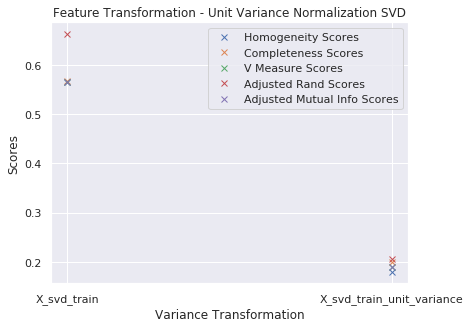

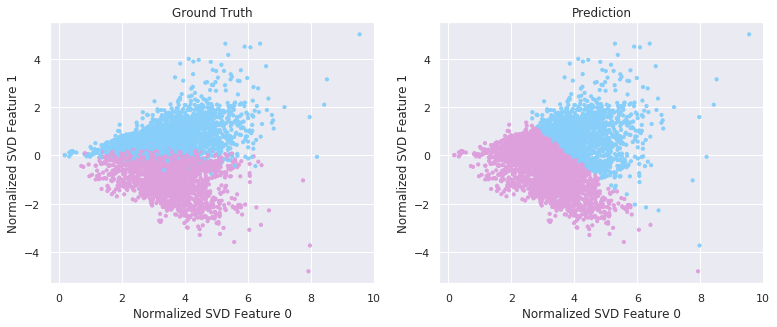

In [0]:
#Best Dimensionality Reduction
SVD = TruncatedSVD(2, random_state =0)

X_svd_train = SVD.fit_transform(X_train_tfidf)
X_svd_test = SVD.transform(X_test_tfidf)

X_svd_train_unit_variance, X_svd_test_unit_variance = unit_variance_transformer(X_svd_train, X_svd_test)

km = KMeans(n_clusters=2, max_iter=1000, n_init=30, verbose=False, random_state=0)

km.fit(X_svd_train)
scores_SVD = scores(km, y_train)

km.fit(X_svd_train_unit_variance)
scores_SVD_unit_variance = scores(km, y_train)

fig = plt.figure()
ax = plt.subplot(111)

concat_scores = np.concatenate((np.array(scores_SVD).reshape(5,1),np.array(scores_SVD_unit_variance).reshape(5,1)),axis=1)
scores_plot(ax, concat_scores)
plt.xticks(np.arange(2),('X_svd_train', 'X_svd_train_unit_variance'))
plt.xlabel('Variance Transformation')
plt.ylabel('Scores')
plt.title('Feature Transformation - Unit Variance Normalization SVD')
ax.legend()
plt.show()

scatter_gnd_truth(km,X_svd_train_unit_variance,y_train,'Normalized SVD Feature 0','Normalized SVD Feature 1','Ground Truth')
scatter_predict(km,X_svd_train_unit_variance,y_train,'Normalized SVD Feature 0','Normalized SVD Feature 1','Prediction')

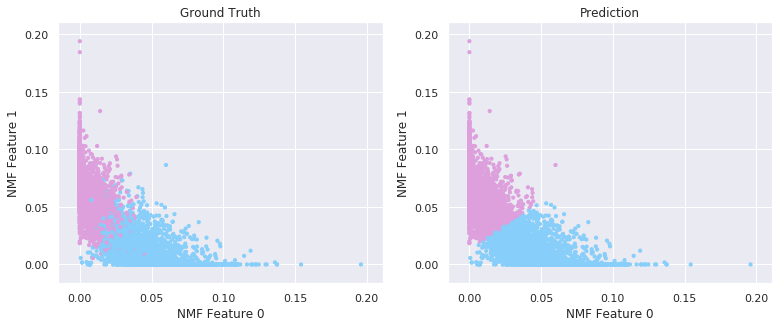

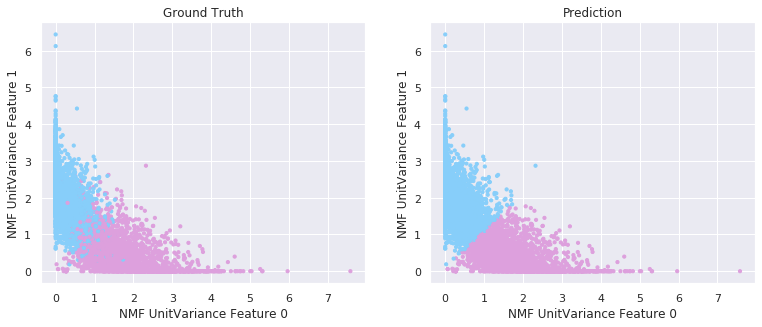

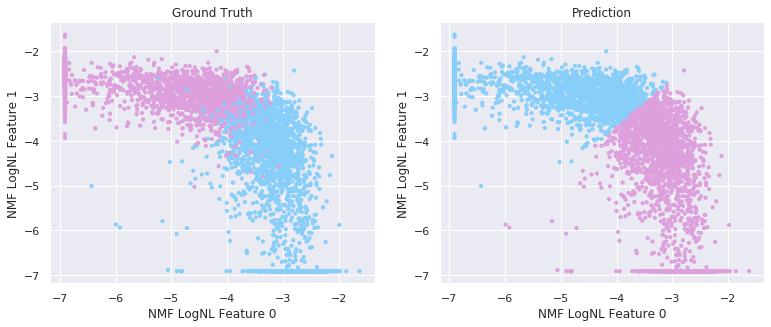

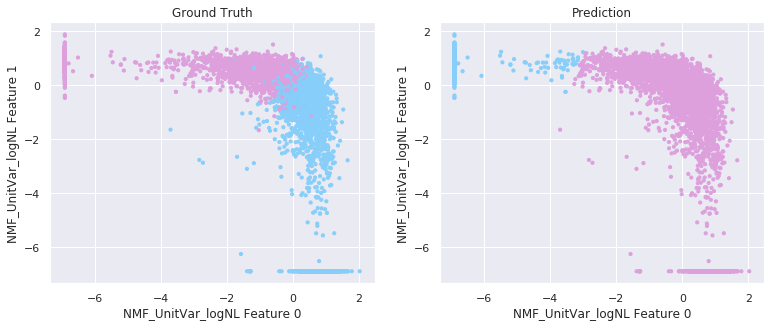

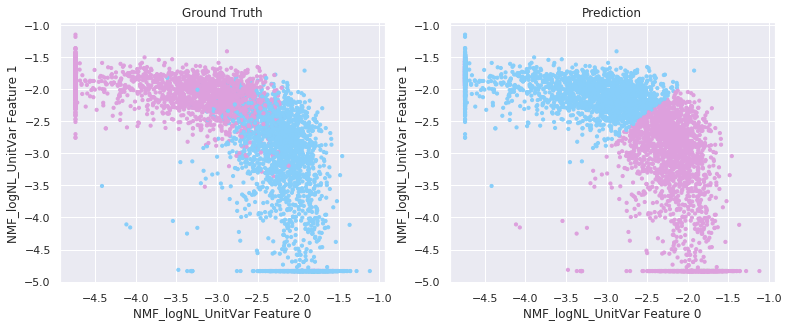

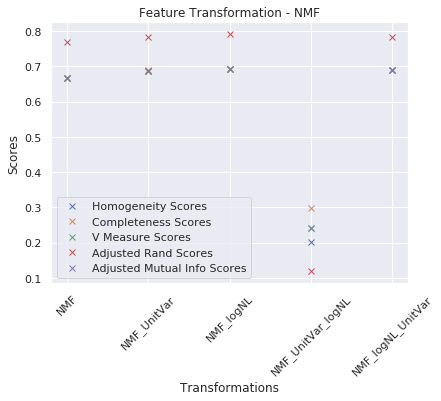

In [0]:
model = NMF(n_components=2, random_state=0)
W_train = model.fit_transform(X_train_tfidf)
W_test = model.transform(X_test_tfidf)

W_train_unit_variance, W_test_unit_variance = unit_variance_transformer(W_train, W_test)
W_train_log_nl, W_test_log_nl = log_nl_transformer(W_train,W_test)
W_train_both, W_test_both = log_nl_transformer(W_train_unit_variance,W_test_unit_variance)
W_train_both2, W_test_both2 = unit_variance_transformer(W_train_log_nl,W_test_log_nl)


km = KMeans(n_clusters=2, max_iter=1000, n_init=30, verbose=False, random_state=0)
km.fit(W_train)
scores_NMF = scores(km, y_train)
scatter_gnd_truth(km,W_train,y_train,'NMF Feature 0','NMF Feature 1','Ground Truth')
scatter_predict(km,W_train,y_train,'NMF Feature 0','NMF Feature 1','Prediction')
#plot_contingency_matrix(km,y_train)

km = KMeans(n_clusters=2, max_iter=1000, n_init=30, verbose=False, random_state=0)
km.fit(W_train_unit_variance)
scores_NMF_unit_variance = scores(km, y_train)
scatter_gnd_truth(km,W_train_unit_variance,y_train,'NMF UnitVariance Feature 0','NMF UnitVariance Feature 1','Ground Truth',True)
scatter_predict(km,W_train_unit_variance,y_train,'NMF UnitVariance Feature 0','NMF UnitVariance Feature 1','Prediction')
#plot_contingency_matrix(km,y_train)

km.fit(W_train_log_nl)
scores_NMF_log_nl = scores(km, y_train)
scatter_gnd_truth(km,W_train_log_nl,y_train,'NMF LogNL Feature 0','NMF LogNL Feature 1','Ground Truth')
scatter_predict(km,W_train_log_nl,y_train,'NMF LogNL Feature 0','NMF LogNL Feature 1','Prediction')
#plot_contingency_matrix(km,y_train)

km.fit(W_train_both)
scores_NMF_both = scores(km, y_train)
scatter_gnd_truth(km,W_train_both,y_train,'NMF_UnitVar_logNL Feature 0','NMF_UnitVar_logNL Feature 1','Ground Truth')
scatter_predict(km,W_train_both,y_train,'NMF_UnitVar_logNL Feature 0','NMF_UnitVar_logNL Feature 1','Prediction')
#plot_contingency_matrix(km,y_train)

km.fit(W_train_both2)
scores_NMF_both2 = scores(km, y_train)
scatter_gnd_truth(km,W_train_both2,y_train,'NMF_logNL_UnitVar Feature 0','NMF_logNL_UnitVar Feature 1','Ground Truth')
scatter_predict(km,W_train_both2,y_train,'NMF_logNL_UnitVar Feature 0','NMF_logNL_UnitVar Feature 1','Prediction')
#plot_contingency_matrix(km,y_train)

fig = plt.figure()
ax = plt.subplot(111)

concat_scores = np.concatenate((np.array(scores_NMF).reshape(5,1),np.array(scores_NMF_unit_variance).reshape(5,1)),axis=1)
concat_scores = np.concatenate((concat_scores,np.array(scores_NMF_log_nl).reshape(5,1)),axis=1)
concat_scores = np.concatenate((concat_scores,np.array(scores_NMF_both).reshape(5,1)),axis=1)
concat_scores = np.concatenate((concat_scores,np.array(scores_NMF_both2).reshape(5,1)),axis=1)

scores_plot(ax, concat_scores)
plt.xticks(np.arange(5),('NMF', 'NMF_UnitVar','NMF_logNL','NMF_UnitVar_logNL','NMF_logNL_UnitVar'),rotation=45)
plt.xlabel('Transformations')
plt.ylabel('Scores')
plt.title('Feature Transformation - NMF')
ax.legend()
plt.show()



In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
dir = 'gdrive/My Drive/michaelscott2.jpg'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def normalizeImage (img):
  #return img/np.dstack((np.sum(img,axis=2),np.sum(img,axis=2),np.ones(img[:,:,2].shape)))
  sumRGB = np.sum(img,axis=2)
  sumRGB[sumRGB == 0] = 1
  return img/np.dstack((sumRGB,sumRGB,sumRGB))

In [0]:
import matplotlib.image as mpimg 
img = mpimg.imread(dir)
norm_img = normalizeImage(img)

imgR = norm_img[:,:,0].reshape(img.shape[0]*img.shape[1])
imgG = norm_img[:,:,1].reshape(img.shape[0]*img.shape[1])

In [0]:
img.shape

(394, 697, 3)

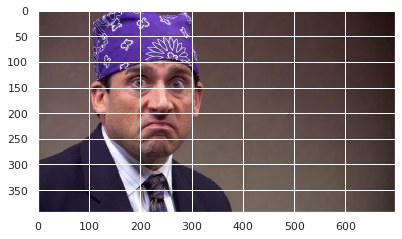

In [0]:
plt.imshow(img) 

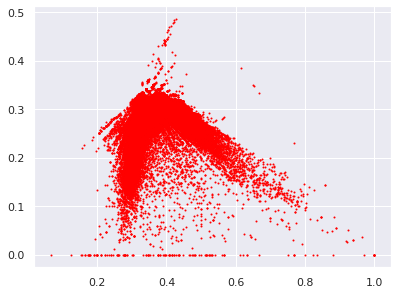

In [0]:
fig = plt.gcf()
ax = fig.add_subplot(111)
scatter = ax.scatter(imgR,imgG,c='red',s=1)
fig.show()

In [0]:
numberClusters = 5
km = KMeans(n_clusters=numberClusters, max_iter=1000, n_init=30, verbose=False, random_state=0)
X = np.concatenate((imgR.reshape(imgR.shape[0],1),imgG.reshape(imgG.shape[0],1)),axis=1)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=5, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=False)

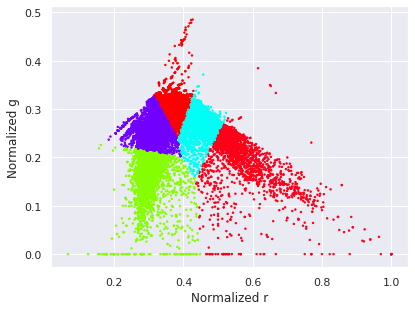

In [0]:
fig = plt.gcf()
plt.set_cmap('hsv')
ax = fig.add_subplot(111)
colors = []
for i in range(X.shape[0]):
  colors.append(km.labels_[i] % numberClusters)   
scatter = ax.scatter(X[range(X.shape[0]),0],X[range(X.shape[0]),1],c=colors,s=2)
plt.xlabel('Normalized r')
plt.ylabel('Normalized g')
fig.show()

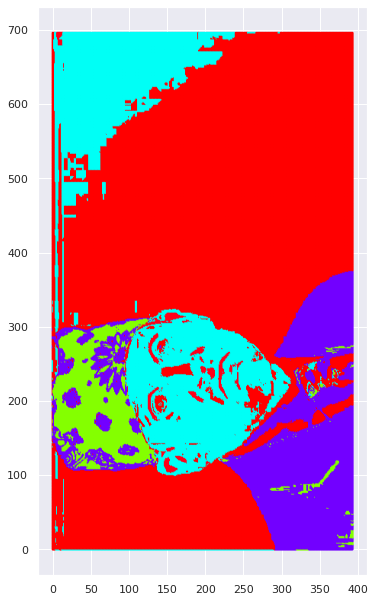

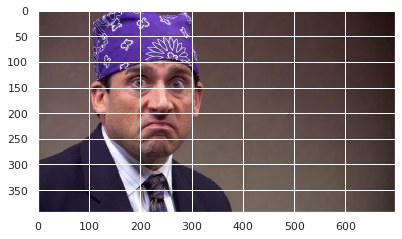

In [0]:
imgX = np.zeros(img.shape[0]*img.shape[1])
imgY = np.zeros(img.shape[0]*img.shape[1])
#i = img.shape[0]*img.shape[1]-1
i=0
fig = plt.figure(figsize=(1.5*3.94,1.5*6.97))
for x in range(img.shape[0]):
  for y in range(img.shape[1]):
    imgX[i] = x
    imgY[i] = y
    #i -= 1
    i += 1
ax = fig.add_subplot(111)
colors = []
for i in range(X.shape[0]):
    colors.append(km.labels_[i] % 10)   
scatter = ax.scatter(imgX,imgY,c=colors,s=1)
fig.show()

fig = plt.figure()
plt.imshow(img) 